In [3]:
import numpy as np  
import matplotlib.pyplot as plt
import pandas as pd
from deap import base, creator, tools, algorithms
import random
import os
# 粒子群参数
C1 = 1.5
C2 = 1.5
W = 0.8
num_particles=50
max_iter=100

# 问题参数
num_year=7
num_crops=41
num_plots1=54
num_plots2=28
num_plots=num_plots1+num_plots2
num_seasons=2


In [7]:
def parse_price(val):
    try:
        if isinstance(val,str) and '-' in val:
            low , high = map(float,val.split('-'))
            return (low+high)/2
      
        return float(val)
    except ValueError:
        return 0.0

## 读取数据

In [10]:
data = pd.read_excel('附件2.xlsx', sheet_name='2023年统计的相关数据')

p=data['销售单价/(元/斤)'].apply(parse_price).values.astype(float)
c=data['种植成本/(元/亩)'].values.astype(float)
q=data['亩产量/斤'].values.astype(float)/2 #斤转换为kg



In [ ]:
#作物种植情况
data_crop_situation = pd.read_excel('附件2.xlsx', sheet_name='2023年的农作物种植情况')
D=data_crop_situation['种植面积/亩'].values.astype(float)*q[(data_crop_situation['作物编号'].values-1)]
# 作物的种植大小




54


In [22]:
A_j=np.array([
    80,55,35,72,68,55,
    60,46,40,28,25,86,55,44,50,25,60,45,35,20,
    15,13,15,18,27,20,
    15,10,14,6,10,12,22,20,
    0.6,0.6,0.6,0.6,0.6,0.6,0.6,0.6,0.6,0.6,0.6,0.6,0.6,0.6,0.6,0.6,
    0.6,0.6,0.6,0.6,
    15,10,14,6,10,12,22,20,
    0.6,0.6,0.6,0.6,0.6,0.6,0.6,0.6,0.6,0.6,0.6,0.6,0.6,0.6,0.6,0.6,
    0.6,0.6,0.6,0.6
])
plot_type=np.array([
    '平旱地','平旱地','平旱地','平旱地','平旱地','平旱地',
    '梯田','梯田','梯田','梯田','梯田','梯田','梯田',
    '梯田','梯田','梯田','梯田','梯田','梯田','梯田',
    '山坡地','山坡地','山坡地','山坡地','山坡地','山坡地',
    '水浇地','水浇地','水浇地','水浇地','水浇地','水浇地','水浇地','水浇地',
    '普通大棚','普通大棚','普通大棚','普通大棚','普通大棚','普通大棚',
    '普通大棚','普通大棚','普通大棚','普通大棚','普通大棚','普通大棚',
    '普通大棚','普通大棚','普通大棚','普通大棚',
    '智慧大棚','智慧大棚','智慧大棚','智慧大棚',
    '水浇地','水浇地','水浇地','水浇地','水浇地','水浇地','水浇地','水浇地',
    '普通大棚','普通大棚','普通大棚','普通大棚','普通大棚','普通大棚',
    '普通大棚','普通大棚','普通大棚','普通大棚','普通大棚','普通大棚',
    '普通大棚','普通大棚','普通大棚','普通大棚',
    '智慧大棚','智慧大棚','智慧大棚','智慧大棚',
])
T_5='普通大棚'
T_6='智慧大棚'



In [ ]:
# 初始化粒子位置和速度
particles=np.zeros((num_particles,num_crops,num_plots,num_seasons,num_year))
v=np.random.rand(num_particles,num_crops,num_plots,num_seasons,num_year)
for n in range(num_particles):
    for j in range(num_plots):
        total_area = A_j[j]
        for k in range(num_seasons):
            for t in range(num_year):
                crop_areas = np.random.dirichlet(np.ones(num_crops)) * total_area
                particles[n][:,j, k, t] = crop_areas

p_best = np.copy(particles)
g_best = np.copy(particles[0])
best_fitness_over_time = []

# 工具函数
def ensure_tenth_multiples(x):  
    return np.round(x * 10) / 10

def objective_function1(x):  # 目标函数
    Z1 = 0
    for t in range(num_year):
        for k in range(num_seasons):
            for i in range(num_crops):
                y_ikt = np.sum(x[i, :, k, t]) * q[i] # 第i类作物在第j个地块在第k个季节在第t年的种植面积*亩产量

                Z1 += p[i] * min(y_ikt, D[i]) - c[i] * np.sum(x[i, :, k, t])# 情况2  +p[i]*0.5*max(0,y_ikt-D[i])

    return Z1

def apply_constraints(particles):  #约束条件
    legume_crop_indices = [1, 2, 3, 4, 5, 17, 18, 19]
    excluded_crops = [35, 36, 37]

    for n in range(num_particles):
        for j in range(num_plots):
            for k in range(num_seasons):
                for t in range(num_year):
                    for i in range(num_crops):
                        min_area = 0
                        if plot_type[j] == '普通大棚' or plot_type[j] == '智慧大棚':
                            min_area = 0.3
                        elif plot_type[j] == '水浇地':
                            min_area = 5
                        else:
                            min_area = 10
                        if 0 < particles[n][i, j, k, t] < min_area:
                            particles[n][i, j, k, t] = min_area

                if plot_type[j] != '水浇地':
                    particles[n][16, j, :, :] = 0

                if plot_type[j] == T_5:
                    for k in range(num_seasons):
                        if k == 0:
                            particles[n][35:38, j, k, t] = 0
                        else:
                            particles[n][0:38, j, k, t] = 0

                if plot_type[j] == T_6:
                    for k in range(num_seasons):
                        particles[n][excluded_crops, j, k, t] = 0

                for i in range(num_crops):
                    for k in range(num_seasons):
                        for t in range(num_year - 1):
                            if particles[n][i, j, k, t] > 0:
                                particles[n][i, j, k, t + 1] = 0

                for i in legume_crop_indices:
                    for t in range(num_year - 2):
                        total_area_over_3 = np.sum(particles[n][i, j, :, t:t + 3])
                        if total_area_over_3 < (A_j[j] / 3):
                            particles[n][i, j, :, t:t + 3] = A_j[j] / 3

                for i in range(num_crops):
                    for k in range(num_seasons):
                        for t in range(num_year):
                            particles[n][i, j, k, t] = ensure_tenth_multiples(particles[n][i, j, k, t])

                total_area = np.sum(particles[n][:, j, k, t])
                if total_area > A_j[j]:
                    particles[n][:, j, k, t] *= A_j[j] / total_area

Iteration 0: -32005601.779210128
Iteration 1: -14946041.083589671
Iteration 2: -15875825.998378284
Iteration 3: -13781407.874869652
Iteration 4: 7539145.41300615
Iteration 5: 6690350.708203498
Iteration 6: 7842275.310092443
Iteration 7: 7502686.586427015
Iteration 8: 6819149.260185117
Iteration 9: 6036922.535528302
Iteration 10: 5870258.7954402
Iteration 11: 5875156.232847305
Iteration 12: 3327667.3031090326
Iteration 13: 3866062.1412461875
Iteration 14: 2337916.54663021
Iteration 15: 2583499.172168823
Iteration 16: -833492.5579238592
Iteration 17: 984290.5879015866
Iteration 18: 1889508.2828761516
Iteration 19: 1462026.9047568163
Iteration 20: 3384830.6650981894
Iteration 21: 3041434.541919074
Iteration 22: 3356295.785811515
Iteration 23: 4300748.290331328
Iteration 24: 1329328.4879334443
Iteration 25: 1582316.7319342121
Iteration 26: 925732.3328743097
Iteration 27: 1227315.989795311
Iteration 28: 779950.8885839555
Iteration 29: 705999.6776996757
Iteration 30: 349966.9451973857
Iterat

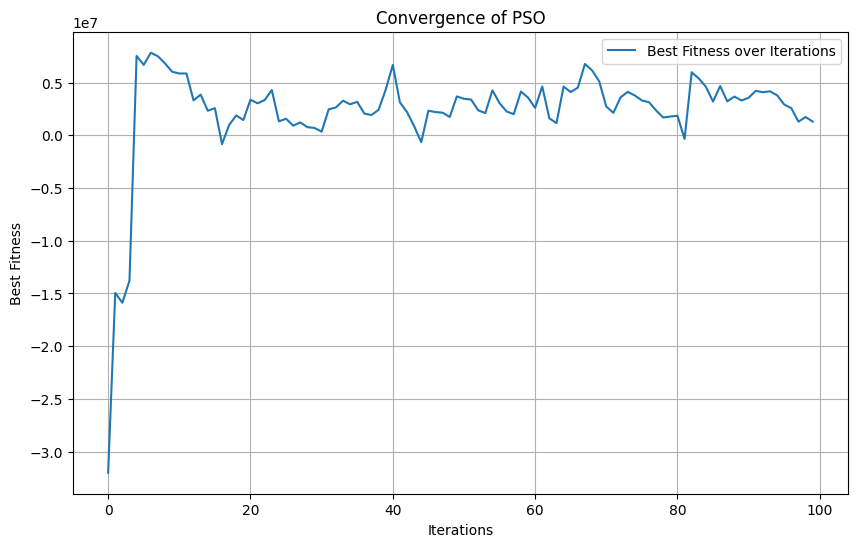

最优解对应的总收益: 1311383.5226472567
解空间矩阵已输出到文件夹: 2023-2029
输出矩阵形状: (41, 82, 2, 7)


In [24]:
def pso():  # 1个用法
    global g_best, p_best, best_fitness_over_time
    folder_name = '2023-2029'
    os.makedirs(folder_name, exist_ok=True)

    for iter in range(max_iter):
        for n in range(num_particles):
            fitness = objective_function1(particles[n])
            if fitness > objective_function1(p_best[n]):
                p_best[n] = particles[n]
            if fitness > objective_function1(g_best):
                g_best = particles[n]

            v[n] = (W * v[n] +C1 * np.random.rand() * (p_best[n] - particles[n]) +
            C2 * np.random.rand() * (g_best - particles[n]))
            particles[n] += v[n]
            particles[n] = np.maximum(particles[n], 0)
            particles[n] = ensure_tenth_multiples(particles[n])

        apply_constraints(particles)
        best_fitness_over_time.append(objective_function1(g_best))
        print(f"Iteration {iter}: {best_fitness_over_time[-1]}")

    return g_best

# 运行PSO
best_solution = pso()
best_value = objective_function1(best_solution)



# 保存输出
output_folder = '2023-2029'
for t in range(num_year):
    for k in range(num_seasons):
        df = pd.DataFrame(best_solution[:, :, k, t],
                         columns=[f"P_{j+1}" for j in range(num_plots)],
                         index=[f"C_{i+1}" for i in range(num_crops)]).T
        df.to_csv(f"{output_folder}/{2024 + t}_Season_{k + 1}.csv")

# 绘图
plt.figure(figsize=(10, 6))
plt.plot(range(len(best_fitness_over_time)), best_fitness_over_time, label='Best Fitness over Iterations')
plt.xlabel('Iterations')
plt.ylabel('Best Fitness')
plt.title('Convergence of PSO')
plt.legend()
plt.grid()
plt.savefig(f"{output_folder}/Convergence_PSO.png")
plt.show()

print("最优解对应的总收益:", best_value)
print(f"解空间矩阵已输出到文件夹: {output_folder}")
print("输出矩阵形状:", best_solution.shape)